In [1]:
## Mount drive:

from google.colab import drive
drive.mount('/content/gdrive')



## Head to drive location that you want:

%cd '/content/gdrive/My Drive/Custom_Traffic_Lights/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Custom_Traffic_Lights


## 1. Download the required dependencies for TensorFlow Object Detection API


In [2]:
# Setting up utilities needed for object detection:

!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models


Cloning into 'models'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 32900 (delta 0), reused 7 (delta 0), pack-reused 32893
Receiving objects: 100% (32900/32900), 511.80 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (21085/21085), done.
Checking out files: 100% (2437/2437), done.


In [3]:

# Dependencies:

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## 2. Set up path to labels and frozen inference graph 


In [0]:
MODEL_NAME = 'ssd_custom_graph_2'
#MODEL_NAME = 'rcnn_custom_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/label_map.pbtxt'
NUM_CLASSES = 3 


#### Loading frozen network:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

#### Set up the labels:

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



## 3. Prepare images that you want to pass into the network

In [7]:
# Preparing images to be passed into the network:

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)



# Setting up the path for random images in the unseen images to be tested:
import random

PATH_TO_TEST_IMAGES_DIR = 'unseen_images'

TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.png'.format(i*random.randint(1,10))) for i in range(1, 5)]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
print(TEST_IMAGE_PATHS)

['unseen_images/1.png', 'unseen_images/6.png', 'unseen_images/24.png', 'unseen_images/12.png']


## 4. Inserting images and visualising the results


829.742431640625 ms
29.511451721191406 ms
28.675079345703125 ms
27.724027633666992 ms


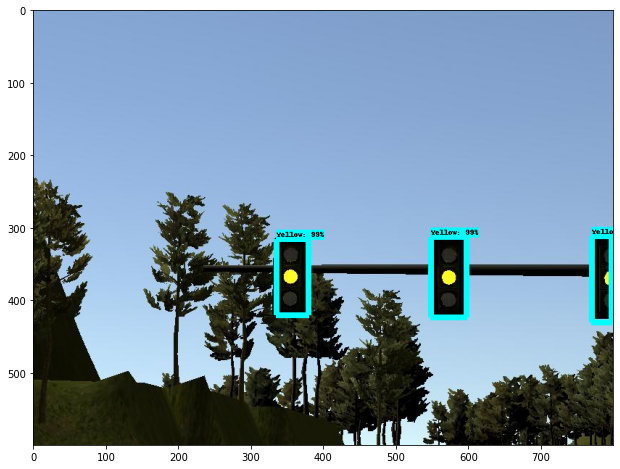

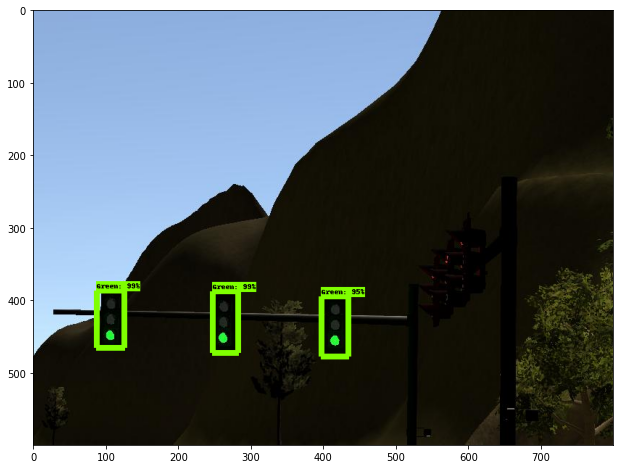

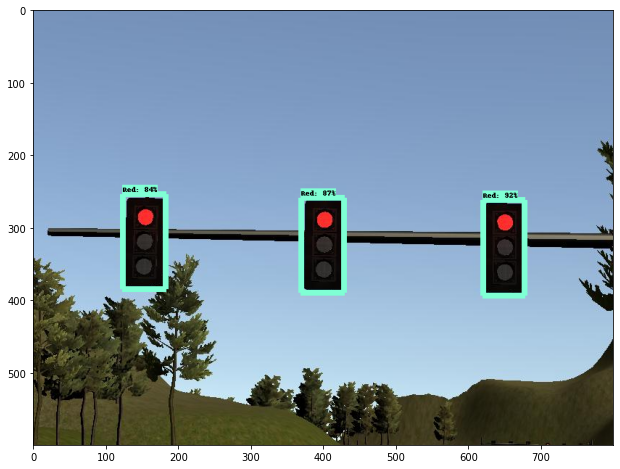

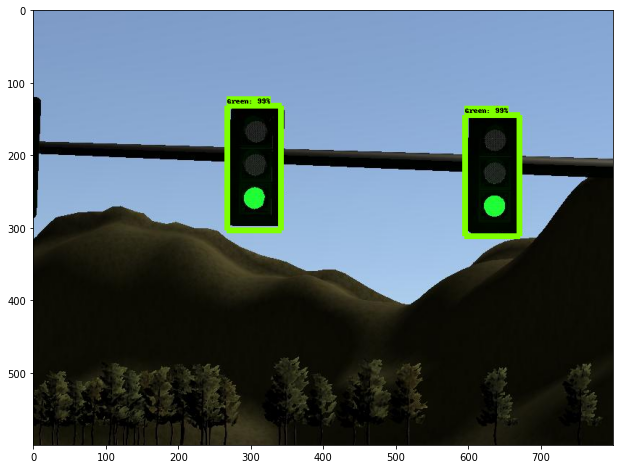

In [8]:
# Initiate forward pass for images:
from matplotlib import pyplot as plt
%matplotlib inline

import time


with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:

    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')


    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.

      start = time.time()

      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
      end = time.time()
      speed = (end-start)*1000
     
      print('{}'.format(speed) + " " + "ms")


      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      